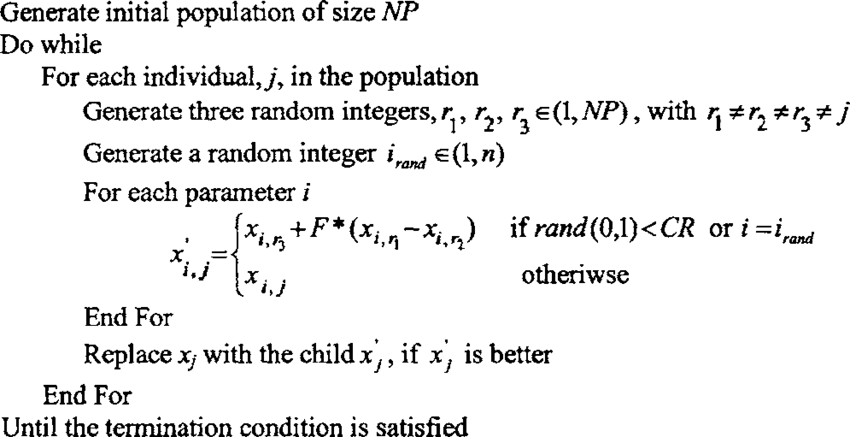

# Initialize

-  n-dimensional 목적함수 $f \ge 0: \mathbb{R}^n \rightarrow \mathbb{R}$, 0에 가까우면 최적
- $x_i = [x_{1, i}, x_{2,i}, ..., x_{n,i}]$: $f$의 후보해
- $NP \ge 4$: Population Size (일반적으로 $NP=10n$)
- $CR \in [0, 1]$: Crossover Probability (일반적으로 $CR=0.9$)
- $F \in [0, 2]$: Differential Weight (일반적으로 $F=0.8$)

# Mutation
- 각 $x_i$마다 $NP$개 후보해 중 세 개의 후보해 $x_{r_1}, x_{r_2}, x_{r_3}$를 선정, 이 때 $r_1 \ne r_2 \ne r_3 \ne j$
- Donor Vector $v_i = x_{r_1} + F(x_{r_2}-x_{r_3})$

In [1]:
import random

def Mutation(target_vector_idx, population, F=0.8):
    
    # r1, r2, r3 추출
    samples = list(range(len(population)))
    samples.remove(target_vector_idx)
    
    rs = random.sample(samples, 3)
    
    # Donor Vector 계산
    target_vector = population[target_vector_idx]
    n_dim = len(target_vector)
    
    donor_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        donor_vector[i] = population[rs[0]][i] + F * (population[rs[1]][i] - population[rs[2]][i])
        
    return donor_vector

# Crossover
- $\begin{align}
x^{'}_{i, j} = \begin{cases}
v_{i,j} &\text{if } rand(0, 1) < CR \\
x_{i,j} &\text{otherwise} \\
\end{cases}
\end{align}$

In [2]:
def Crossover(target_vector, donor_vector, CR=0.9):
    n_dim = len(target_vector)
    
    trial_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        if random.random() < CR:
            trial_vector[i] = donor_vector[i]
        else:
            trial_vector[i] = target_vector[i]
            
    return trial_vector

# Selection
- $x_i \leftarrow x^{'}_i \text{ if } f(x^{'}_i) \le f(x_i)$

In [3]:
def Selection(f, target_vector, trial_vector):
    if f(trial_vector) <= f(target_vector):
        return trial_vector
    else:
        return target_vector

# DE

In [4]:
def DE(f, population, F=0.8, CR=0.9, iters=100, score_want=5, verbose=False):
    """
    Parameter
    ---------
    f: 0보다 크거나 같으며 0이 될 때 최적해인 목적 함수
    population: 후보해 (len(p)>= 4), NP x n_dim list
    F: Differential Weight, default=0.8, [0, 2]
    CR: Crossover Probability, default=0.9, [0, 1]
    iters: 최대 반복 횟수, default=100
    score_want: f로 계산된 점수가 score_want보다 작으면 알고리즘 종료, default=5
    verbose: 반복이 끝날 때마다 점수 출력여부, default=False
    
    
    Returns
    -------
    best_pop, best_score
        
    
    Example
    -------
    def fitness(indivisual, model=xgb, goal=800):
        pred = model.predict([indivisual])[0]

        score = 100 - abs(pred - goal)
    return score
    
    population = X_features.values.tolist()[:100]
    best_pop, best_score = DE(lambda x:fitness(x), population)
    
    """
    assert (F >= 0) and (F <= 2), "F needs to be in [0, 2]"
    assert (CR >= 0) and (CR <= 1), "CR needs to be in [0, 1]"
    
    NP = len(population)
    assert NP >= 4, "len(Population) >= 4"
    
    import copy
    population = copy.deepcopy(population)
    
    # 만족할 때까지 반복
    for n_trial in range(iters):
        for j in range(NP):
            target_vector = population[j]
            donor_vector = Mutation(j, population, F)
            trial_vector = Crossover(target_vector, donor_vector, CR)
            selected_vector = Selection(f, target_vector, trial_vector)
            
            population[j] = selected_vector
            
        # 점수 계산
        scores = list(map(f, population))
        best_score = min(scores)
        if verbose:
            print(f'{n_trial:3d}: {best_score:.1f}')
        if best_score < score_want:
            break
    
    best_idx = min(range(NP), key=lambda x:scores[x])
    best_pop = population[best_idx]
    
    return best_pop, best_score

# 변형
- DE/rand/1: $v_i = x_{r_1} + F(x_{r_2}-x_{r_3})$
- DE/best/1: $v_i = x_{\text{best}} + F(x_{r_1}-x_{r_2})$
- DE/best/2: $v_i = x_{\text{best}} + F(x_{r_1}+x_{r_2}-x_{r_3}-x_{r_4})$
- DE/rand-to-best/1: $v_i = x_{i} + \lambda (x_{best}-x_{i}) + F(x_{r_2}-x_{r_3})$, 보통 $\lambda = F$

In [5]:
def Mutation_rand1(target_vector_idx, population, F=0.8):
    NP = len(population)
    
    # r1, r2, r3 추출
    samples = list(range(NP))
    samples.remove(target_vector_idx)

    rs = random.sample(samples, 3)

    # Donor Vector 계산
    target_vector = population[target_vector_idx]
    n_dim = len(target_vector)

    donor_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        donor_vector[i] = population[rs[0]][i] + F * (population[rs[1]][i] - population[rs[2]][i])

    return donor_vector


def Mutation_best1(f, target_vector_idx, population, F=0.8):
    NP = len(population)
    
    # 자기 자신 제외 best 추출
    samples = list(range(NP))
    samples.remove(target_vector_idx)
    
    
    best_idx = min(samples, key=lambda x:f(population[x]))
    best_vector = population[best_idx]

    # r1, r2 추출
    samples.remove(best_idx) 

    rs = random.sample(samples, 2)

    # Donor Vector 계산
    target_vector = population[target_vector_idx]
    n_dim = len(target_vector)

    donor_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        donor_vector[i] = best_vector[i] + F * (population[rs[0]][i] - population[rs[1]][i])

    return donor_vector


def Mutation_best2(f, target_vector_idx, population, F=0.8):
    NP = len(population)
    
    # 자기 자신 제외 best 추출
    samples = list(range(NP))
    samples.remove(target_vector_idx)
    
    
    best_idx = min(samples, key=lambda x:f(population[x]))
    best_vector = population[best_idx]

    # r1, r2, r3, r4 추출
    samples.remove(best_idx)  

    rs = random.sample(samples, 4)

    # Donor Vector 계산
    target_vector = population[target_vector_idx]
    n_dim = len(target_vector)

    donor_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        donor_vector[i] = best_vector[i] + F * (population[rs[0]][i] + population[rs[1]][i]
                                               -population[rs[2]][i] - population[rs[3]][i])

    return donor_vector


def Mutation_rand2best(f, target_vector_idx, population, F=0.8, lam=None):
    NP = len(population)
    
    
    # lambda 정의
    if lam is None:
        lam = F

    # 자기 자신 제외 best 추출
    samples = list(range(NP))
    samples.remove(target_vector_idx)
    
    
    best_idx = min(samples, key=lambda x:f(population[x]))
    best_vector = population[best_idx]

    # r1, r2, r3 추출
    samples.remove(best_idx) 

    rs = random.sample(samples, 3)

    # Donor Vector 계산
    target_vector = population[target_vector_idx]
    n_dim = len(target_vector)

    donor_vector = [0 for _ in range(n_dim)]
    for i in range(n_dim):
        donor_vector[i] = target_vector[i] + \
                          lam * (best_vector[i] - target_vector[i]) + \
                          F * (population[rs[0]][i] + population[rs[1]][i])

    return donor_vector

In [6]:
def DE_variant(f, population, F=0.8, CR=0.9, iters=100, score_want=5, verbose=False, method='rand1', lam=None):
    """
    Parameter
    ---------
    f: 0보다 크거나 같으며 0이 될 때 최적해인 목적 함수
    population: 후보해 (len(p)>= 4), NP x n_dim list
    F: Differential Weight, default=0.8, [0, 2]
    CR: Crossover Probability, default=0.9, [0, 1]
    iters: 최대 반복 횟수, default=100
    score_want: f로 계산된 점수가 score_want보다 작으면 알고리즘 종료, default=5
    verbose: 반복이 끝날 때마다 점수 출력여부, default=False
    method: 변형. default='rand1'
        "rand1": Mutation 시 랜덤 추출 후 계산
        "best1": Mutation 시 최적해 추출 후 차이 한 번 계산
        "best2": Mutation 시 최적해 추출 후 차이 두 번 계산
        "rand2best": Mutation 시 랜덤&최적해 동시 추출 후 계산
    lam: method가 "rand2best"인 경우 사용, default=None. None인 경우 F 사용
    
    Returns
    -------
    best_pop, best_score
        
    
    Example
    -------
    def fitness(indivisual, model=xgb, goal=800):
        pred = model.predict([indivisual])[0]

        score = 100 - abs(pred - goal)
    return score
    
    population = X.values.tolist()[:100]
    best_pop, best_score = DE(lambda x:fitness(x), population)
    
    """
    assert (F >= 0) and (F <= 2), "F needs to be in [0, 2]"
    assert (CR >= 0) and (CR <= 1), "CR needs to be in [0, 1]"
    
    NP = len(population)
    assert NP >= 4, "len(Population) >= 4"
    
    import copy
    population = copy.deepcopy(population)
    new_population = [0 for _ in range(NP)]
    
    # 만족할 때까지 반복
    for n_trial in range(iters):
        for j in range(NP):
            target_vector = population[j]
            if method == 'rand1':
                donor_vector = Mutation_rand1(j, population, F)
            elif method == 'best1':
                donor_vector = Mutation_best1(f, j, population, F)
            elif method == 'best2':
                donor_vector = Mutation_best2(f, j, population, F)
            elif method == 'rand2best':
                donor_vector = Mutation_rand2best(f, j, population, F, lam)
            trial_vector = Crossover(target_vector, donor_vector, CR)
            selected_vector = Selection(f, target_vector, trial_vector)
            
            new_population[j] = selected_vector
        population = new_population
            
        # 점수 계산
        scores = list(map(f, population))
        best_score = min(scores)
        if verbose:
            print(f'{n_trial:3d}: {best_score:.1f}')
        if best_score < score_want:
            break
    
    best_idx = min(range(NP), key=lambda x:scores[x])
    best_pop = population[best_idx]
    
    return best_pop, best_score

# 자전거 수요 예측 예시

In [7]:
import pandas as pd

df = pd.read_csv('bike.csv')
# df['datetime'] = df.datetime.apply(pd.to_datetime)

# df['year'] = df.datetime.apply(lambda x : x.year)
# df['month'] = df.datetime.apply(lambda x : x.month)
# df['day'] = df.datetime.apply(lambda x : x.day)
# df['hour'] = df.datetime.apply(lambda x : x.hour)

drop_columns = ['datetime', 'casual', 'registered']
df.drop(drop_columns, axis=1, inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,0,0,1,9.84,14.395,81,0.0,16
1,1,0,0,1,9.02,13.635,80,0.0,40
2,1,0,0,1,9.02,13.635,80,0.0,32
3,1,0,0,1,9.84,14.395,75,0.0,13
4,1,0,0,1,9.84,14.395,75,0.0,1


In [8]:
y_target = df['count']
X_features = df.drop(['count'], axis=1)

In [9]:
from xgboost import XGBRegressor

xgb = XGBRegressor().fit(X_features.values, y_target.values)

In [10]:
def fitness(indivisual, model=xgb, goal=800):
    pred = model.predict([indivisual])[0]
    
    score = abs(pred - goal)
    
    return score

In [11]:
population = X_features.values.tolist()[-100:]

In [12]:
best_pop, best_score = DE_variant(lambda x:fitness(x, goal=900), population, method='rand1', score_want=10, verbose=True)

  0: 534.0
  1: 297.8
  2: 297.8
  3: 185.7
  4: 145.8
  5: 33.9
  6: 33.9
  7: 33.9
  8: 33.9
  9: 33.9
 10: 33.9
 11: 33.9
 12: 33.9
 13: 33.9
 14: 33.9
 15: 33.9
 16: 33.9
 17: 33.9
 18: 33.9
 19: 33.9
 20: 33.9
 21: 33.9
 22: 8.4


In [13]:
best_pop

[4.0,
 0.0,
 -33.60833858873721,
 50.00147542446048,
 -99.8854322496631,
 237.76368734655216,
 32.720345558445366,
 175.877438354063]

In [14]:
xgb.predict([best_pop])

array([908.3856], dtype=float32)

In [15]:
best_pop, best_score = DE_variant(lambda x:fitness(x, goal=900), population, method='best1', score_want=10, verbose=True)

  0: 387.7
  1: 387.7
  2: 378.0
  3: 378.0
  4: 378.0
  5: 378.0
  6: 190.0
  7: 190.0
  8: 190.0
  9: 178.8
 10: 5.3


In [16]:
best_pop

[4.0,
 0.0,
 -0.003859007268455318,
 -1.5631951388672012,
 29.38460007347521,
 46.39529653962513,
 27.645150532698107,
 -61.05198134821589]

In [17]:
xgb.predict([best_pop])

array([894.7311], dtype=float32)

In [18]:
best_pop, best_score = DE_variant(lambda x:fitness(x, goal=900), population, method='best2', score_want=10, verbose=True)

  0: 338.7
  1: 156.9
  2: 156.9
  3: 46.3
  4: 46.3
  5: 46.3
  6: 46.3
  7: 46.3
  8: 46.3
  9: 46.3
 10: 46.3
 11: 46.3
 12: 14.9
 13: 14.9
 14: 14.9
 15: 14.9
 16: 14.9
 17: 14.9
 18: 4.1


In [19]:
best_pop

[4.0,
 0.0,
 -36.043140847516355,
 35.141220824835266,
 -93.06221722558311,
 175.57954274055191,
 43.2801228717232,
 485.2820233522456]

In [20]:
xgb.predict([best_pop])

array([904.1114], dtype=float32)

In [21]:
best_pop, best_score = DE_variant(lambda x:fitness(x, goal=900), population, method='rand2best', score_want=10, verbose=True)

  0: 324.9
  1: 324.9
  2: 324.9
  3: 324.9
  4: 324.9
  5: 324.9
  6: 324.9
  7: 324.9
  8: 324.9
  9: 324.9
 10: 324.9
 11: 324.9
 12: 324.9
 13: 324.9
 14: 317.8
 15: 317.8
 16: 317.8
 17: 317.8
 18: 317.8
 19: 317.8
 20: 317.8
 21: 317.8
 22: 317.8
 23: 317.8
 24: 317.8
 25: 317.8
 26: 317.8
 27: 317.8
 28: 317.8
 29: 317.8
 30: 317.8
 31: 317.8
 32: 317.8
 33: 317.8
 34: 317.8
 35: 317.8
 36: 317.8
 37: 317.8
 38: 317.8
 39: 317.8
 40: 317.8
 41: 317.8
 42: 317.8
 43: 317.8
 44: 317.8
 45: 317.8
 46: 317.8
 47: 317.8
 48: 231.1
 49: 231.1
 50: 231.1
 51: 231.1
 52: 231.1
 53: 231.1
 54: 231.1
 55: 231.1
 56: 231.1
 57: 231.1
 58: 231.1
 59: 231.1
 60: 231.1
 61: 231.1
 62: 231.1
 63: 231.1
 64: 231.1
 65: 231.1
 66: 231.1
 67: 231.1
 68: 231.1
 69: 231.1
 70: 231.1
 71: 231.1
 72: 231.1
 73: 231.1
 74: 231.1
 75: 231.1
 76: 231.1
 77: 231.1
 78: 231.1
 79: 231.1
 80: 231.1
 81: 231.1
 82: 231.1
 83: 231.1
 84: 231.1
 85: 231.1
 86: 231.1
 87: 231.1
 88: 231.1
 89: 231.1
 90: 231.1

In [22]:
best_pop

[454064.09713844216,
 0.0,
 41761.869008133894,
 113163.3326424736,
 15.58,
 2254916.091525523,
 46.0,
 3223.2631649466102]

In [23]:
xgb.predict([best_pop])

array([668.86127], dtype=float32)